In [1]:
# %%capture
# !pip install box2d-py

In [2]:
import os
import cv2
import gym
import time
import collections

import numpy as np
import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
# T.cuda.get_device_name()

## **Replay Buffer**

In [4]:
class ReplayBuffer:
    def __init__(self, mem_size, observation_shape, n_actions):
        self.mem_size = mem_size
        self.mem_counter = 0
        # DATA
        self.states = np.zeros((mem_size, *observation_shape), dtype=np.float32)
        self.actions = np.zeros((mem_size , n_actions), dtype=np.float32)
        self.rewards = np.zeros(mem_size, dtype=np.float32)
        self.states_ = np.zeros((mem_size, *observation_shape), dtype=np.float32)
        self.terminals = np.zeros(mem_size, dtype=bool)

    # STORE TRANSITIONS IN BUFFER
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.states_[index] = state_
        self.terminals[index] = done # 1 if 'done' else 0
        self.mem_counter += 1

    # UNIFORMLY SAMPLES 'BUFFER' AND RETURNS A 'BATCH' OF batch_size
    def sample_batch(self, batch_size):
        max_index = min(self.mem_counter, self.mem_size)
        batch_indices = np.random.choice(max_index, batch_size, replace=False)
        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        terminals = self.terminals[batch_indices]
        return (states, actions, rewards, states_, terminals)

## **Networks**

In [5]:
class ActorNetwork(nn.Module):
    def __init__(self, lr, observation_shape, fc1_size, fc2_size, n_actions, model_name, model_dir):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name+'_ACTOR')
        # ANN
        self.fc1 = nn.Linear(observation_shape[0], fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, n_actions)          
        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(self.device)

    def forward(self, state):
        mu = self.fc1(state)
        mu = F.relu(mu)
        mu = self.fc2(mu)
        mu = F.relu(mu)
        mu = self.out(mu)
        mu = F.tanh(mu)
        return mu #mu = a

    def save_model(self):
        print("[INFO] ACTOR - Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] ACTOR - Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [6]:
class CriticNetwork(nn.Module):
    def __init__(self, lr, observation_shape, fc1_size, fc2_size, n_actions, model_name, model_dir):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name+'_CRITIC')
        # ANN
        self.fc1 = nn.Linear(observation_shape[0]+n_actions, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.out = nn.Linear(fc2_size, 1)
        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=0.001)
        self.to(self.device)

    def forward(self, state, action):
        q = self.fc1(T.cat([state, action], dim=1))
        q = F.relu(q)
        q = self.fc2(q)
        q = F.relu(q)
        q = self.out(q)
        return q

    def save_model(self):
        print("[INFO] CRITIC - Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] CRITIC - Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## **Agent**

In [7]:
class TD3gent:
    def __init__(self, env, observation_shape, n_actions, actor_lr, critic_lr, fc1_size, fc2_size, tau, gamma, action_noise_sd,
                 mem_size, batch_size, actor_replace_interval, warmup, algo_name, env_name, model_dir):
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.A_LR = actor_lr
        self.C_LR = critic_lr
        self.TAU = tau
        self.GAMMA = gamma
        self.action_clamp = {
            'low':env.action_space.low[0],
            'high':env.action_space.high[0]
        }
        self.action_noise_sd = action_noise_sd

        # MEM PARAMS
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, observation_shape, n_actions)

        # MODEL PARAMS
        self.move_counter = 0
        self.warmup = warmup
        self.learn_counter = 0
        self.actor_replace_interval = actor_replace_interval
        self.algo_name = algo_name
        self.env_name = env_name
        self.model_dir = model_dir
        # A1
        self.A_STEP = ActorNetwork(actor_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_STEP',
                              model_dir = model_dir)
        # A2
        self.A_TARGET = ActorNetwork(actor_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_TARGET',
                              model_dir = model_dir)
        # C1a
        self.C_STEP_a = CriticNetwork(critic_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_STEP_a',
                              model_dir = model_dir)
        # C1b
        self.C_STEP_b = CriticNetwork(critic_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_STEP_b',
                              model_dir = model_dir)
        # C2a
        self.C_TARGET_a = CriticNetwork(critic_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_TARGET_a',
                              model_dir = model_dir)
        # C2b
        self.C_TARGET_b = CriticNetwork(critic_lr, observation_shape, fc1_size, fc2_size, n_actions,
                              model_name = env_name+'_'+algo_name+'_TARGET_b',
                              model_dir = model_dir)
        self.update_target_networks(tau=1) # HARD UPDATE ON INIT
    
    def get_action(self, observation, eval=False):
        self.A_STEP.eval()
        # OBSERVATION TO TENSOR
        observation = T.tensor(observation, dtype=T.float32).to(self.A_STEP.device)
        state = T.unsqueeze(observation, 0)                                     # T.tensor([array]) = T.unsqueeze(T.tensor(array), 0)
        # GET mu = A1(s)
        mu = self.A_STEP(state)
        if (eval):
            mu_PRIME = mu
        else:
            mu_PRIME = mu + (T.tensor(np.random.normal(scale=self.action_noise_sd), dtype=T.float32).to(self.A_STEP.device)) # SHAPE (1,4) + (1)
            mu_PRIME = T.clamp(mu_PRIME, self.action_clamp['low'], self.action_clamp['high'])
        self.A_STEP.train()
        
        return mu_PRIME.cpu().detach().numpy()[0]

    def learn(self):
        if (self.memory.mem_counter < self.batch_size): 
            return # return if insufficient samples present
        
        self.learn_counter += 1
        states, actions, rewards, states_, terminals = self.sample_batch()

        # CALC  q1a = C1a(s, a) & q1b = C1b(s, a)
        q1a_preds = self.C_STEP_a(states, actions)
        q1b_preds = self.C_STEP_b(states, actions)
        
        # GET   a2_ = A2(s_) + N(sd=0.2, -5 to 5)  total clamped between (min,max)
        a2_ = self.A_TARGET(states_)
        a2_ = a2_ + T.clamp(T.tensor(np.random.normal(scale=0.2)), -0.5, 0.5) # NOISE
        a2_ = T.clamp(a2_, self.action_clamp['low'], self.action_clamp['high'])
        # GET  q2a_ = C2a(s_, a2_) & q2b_ = C2b(s_, a2_)
        # CALC q2_ = min(q2a_, q2b_)
        # CALC Q2 = R + (gamma * q2_)
        q2a_next = self.C_TARGET_a(states_, a2_)
        q2b_next = self.C_TARGET_b(states_, a2_)
        q2a_next[terminals] = 0.0
        q2b_next[terminals] = 0.0
        q2a_next = q2a_next.view(-1)
        q2b_next = q2b_next.view(-1)
        q2_next = T.min(q2a_next, q2b_next)
        q2_targets = rewards + (self.GAMMA * q2_next)
        q2_targets = q2_targets.view(self.batch_size, 1)

        # CRITIC LOSS
        critic_a_loss = F.mse_loss(q1a_preds, q2_targets)
        critic_b_loss = F.mse_loss(q1b_preds, q2_targets)
        critic_loss = critic_a_loss + critic_b_loss
        # BACKPROP CRITICS
        self.C_STEP_a.optimizer.zero_grad()
        self.C_STEP_b.optimizer.zero_grad()
        critic_loss.backward()
        self.C_STEP_a.optimizer.step()
        self.C_STEP_b.optimizer.step()

        if (self.learn_counter % self.actor_replace_interval != 0):
            return # RETURN IF NOT TURN TO UPDATE ACTOR

        # ACTOR LOSS
        actor_loss = -(self.C_STEP_a(states, self.A_STEP(states)))
        actor_loss = T.mean(actor_loss)
        self.A_STEP.optimizer.zero_grad()
        actor_loss.backward()
        self.A_STEP.optimizer.step()
        
        # UPDATE WEIGHTS OF TARGET NETWORK
        self.update_target_networks()

    def update_target_networks(self, tau=None):
        TAU = self.TAU if tau is None else tau

        A1_state_dict =  dict(self.A_STEP.named_parameters())
        C1a_state_dict =  dict(self.C_STEP_a.named_parameters())
        C1b_state_dict =  dict(self.C_STEP_b.named_parameters())
        A2_state_dict =  dict(self.A_TARGET.named_parameters())
        C2a_state_dict =  dict(self.C_TARGET_a.named_parameters())
        C2b_state_dict =  dict(self.C_TARGET_b.named_parameters())
        # SOFT UPDATE
        for name in A1_state_dict:
            A1_state_dict[name] = (TAU *  A1_state_dict[name].clone()) + ((1-TAU)* A2_state_dict[name].clone())
        for name in C1a_state_dict:
            C1a_state_dict[name] = (TAU *  C1a_state_dict[name].clone()) + ((1-TAU)* C2a_state_dict[name].clone())
        for name in C1b_state_dict:
            C1b_state_dict[name] = (TAU *  C1b_state_dict[name].clone()) + ((1-TAU)* C2b_state_dict[name].clone())
        # UPDATE TARGET WEIGHTS
        self.A_TARGET.load_state_dict(A1_state_dict)
        self.C_TARGET_a.load_state_dict(C1a_state_dict)
        self.C_TARGET_b.load_state_dict(C1b_state_dict)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_batch(self):
        states, actions, rewards, states_, terminals = self.memory.sample_batch(self.batch_size)
        states = T.tensor(states).to(self.A_STEP.device)
        actions = T.tensor(actions).to(self.A_STEP.device)
        rewards = T.tensor(rewards).to(self.A_STEP.device)
        states_ = T.tensor(states_).to(self.A_STEP.device)
        terminals = T.tensor(terminals).to(self.A_STEP.device)
        return states, actions, rewards, states_, terminals    

    def save_models(self):
        self.A_STEP.save_model()
        self.A_TARGET.save_model()
        self.C_STEP_a.save_model()
        self.C_STEP_b.save_model()
        self.C_TARGET_a.save_model()
        self.C_TARGET_b.save_model()

    def load_models(self, cpu=False):
        self.A_STEP.load_model(cpu)
        self.A_TARGET.load_model(cpu)
        self.C_STEP_a.load_model(cpu)
        self.C_STEP_b.load_model(cpu)
        self.C_TARGET_a.load_model(cpu)
        self.C_TARGET_b.load_model(cpu)

## **Training**

In [7]:
env_name = "BipedalWalker-v3"
env = gym.make(env_name)

N_EPISODES = 1500

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
agent = TD3gent(env=env,
                observation_shape=env.observation_space.shape,
                n_actions=env.action_space.shape[0],
                actor_lr=1e-3,
                critic_lr=1e-3,
                fc1_size=400,
                fc2_size=300,
                tau=0.005,
                gamma=0.99,
                action_noise_sd=0.1,
                mem_size=100000,
                batch_size=100,
                actor_replace_interval=2, 
                warmup=1000,
                algo_name='TD3',
                env_name=env_name,
                model_dir='./weights')

In [ ]:
episode_rewards, episode_lengths, mean_rewards = [],[],[]
best_reward = -np.inf

for episode_n in tqdm(range(N_EPISODES)):
    total_reward, total_moves = 0,0

    done = False
    observation = env.reset()

    while not done:
        agent.move_counter += 1
        if (agent.move_counter < agent.warmup):
            action = env.action_space.sample()
        else:
            action = agent.get_action(observation)

        observation_, reward, done, _ = env.step(action)

        total_reward += reward
        total_moves += 1

        # STORE DATA & LEARN
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()

        observation = observation_
    
    episode_rewards.append(total_reward)
    episode_lengths.append(total_moves)
    
    mean_reward = np.mean(episode_rewards[-100:])
    mean_rewards.append(mean_reward)
    if(mean_reward > best_reward):
        agent.save_models()
        best_reward = mean_reward
    
    print("ITER: ",episode_n,"\tRWD: ",round(total_reward,2),"\tM_RWD: ",round(mean_reward,2),"\tLEN: ",total_moves)    

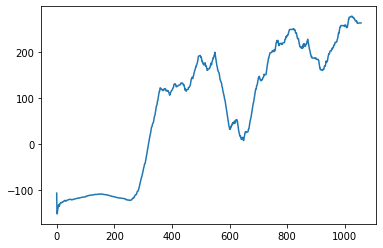

In [10]:
plt.plot(mean_rewards)

## **Testing**

In [8]:
env_name = "BipedalWalker-v3"
env = gym.make(env_name)

agent = TD3gent(env=env,
                observation_shape=env.observation_space.shape,
                n_actions=env.action_space.shape[0],
                actor_lr=1e-3,
                critic_lr=1e-3,
                fc1_size=400,
                fc2_size=300,
                tau=0.005,
                gamma=0.99,
                action_noise_sd=0.1,
                mem_size=1,
                batch_size=1,
                actor_replace_interval=2, 
                warmup=1000,
                algo_name='TD3',
                env_name=env_name,
                model_dir='./weights')

In [9]:
agent.load_models(cpu=True)

[INFO] ACTOR - Loading model
[INFO] ACTOR - Loading model
[INFO] CRITIC - Loading model
[INFO] CRITIC - Loading model
[INFO] CRITIC - Loading model
[INFO] CRITIC - Loading model


In [11]:
# 'agent.get_action' automatically sets 'model' to 'eval' mode
with T.no_grad():
    total_reward, total_moves = 0,0
    done = False
    observation = env.reset()

    while not done:
        time.sleep(0.0001)
        env.render()

        # e_GREEDY ACTION
        action = agent.get_action(observation, eval=True)
        observation_, reward, done, _ = env.step(action)

        total_reward += reward
        total_moves += 1

        observation = observation_
    print("RWD: ",total_reward,"\tLEN: ",total_moves)
    env.close()

RWD:  302.02251024397117 	LEN:  744
